## Pin location estimator

In [1]:
import numpy as np
import pandas as pd
import os, shutil
import glob
from scipy import stats
import cv2

from IPython.display import Image
from IPython.display import display
from statistics import mode

In [131]:
# Global variable
total_pin_detected=0

# Function Definition
def set_total_pin_detected(val):
    total_pin_detected=val
    
def bb_intersection_ratio(boxA, boxB):
    xA = max(float(boxA["x1"]), float( boxB["x1"]))
    yA = max(float(boxA["y1"]), float(boxB["y1"]))
    xB = min(float(boxA["x2"]), float(boxB["x2"]))
    yB = min(float(boxA["y2"]), float(boxB["y2"]))
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    boxAArea = (float(boxA["x2"]) - float(boxA["x1"]) + 1) * (float(boxA["y2"]) - float(boxA["y1"]) + 1)
    percentage_area = interArea / float(boxAArea ) *100
    return percentage_area

def best_fit_slope_and_intercept(xs,ys):
    m = (((np.mean(xs)*np.mean(ys)) - np.mean(xs*ys)) /
         ((np.mean(xs)*np.mean(xs)) - np.mean(xs*xs)))
    b = np.mean(ys) - m*np.mean(xs)
    return m, b

def dimension_outfilter(df, col):
    values = np.abs(np.array(df[col])/np.median(df[col]))
    return df[(values > .75) & (values < 1.25)]

def get_df(txt_file):
    return pd.read_csv(txt_file, names=['x1', 'y1', 'x2', 'y2', 'class', 'score'],  dtype={'x1': np.int, 'y1': np.int, 'x2': np.int, 'y2': np.int, 'class':str, 'score':float} )

def get_txt_df(txt_file):
    return pd.read_csv(txt_file, names=['x1', 'y1', 'x2', 'y2', 'class'],  dtype={'x1': np.int, 'y1': np.int, 'x2': np.int, 'y2': np.int, 'class':str} )


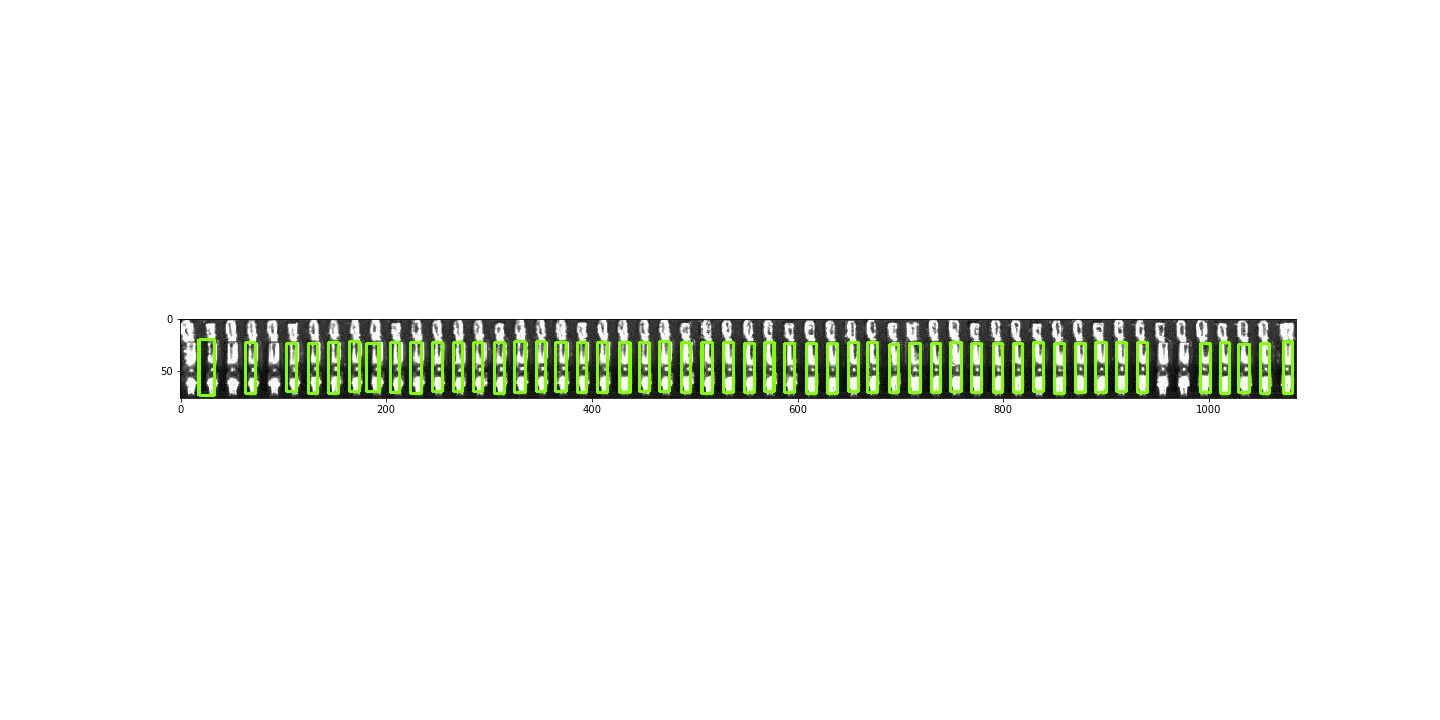

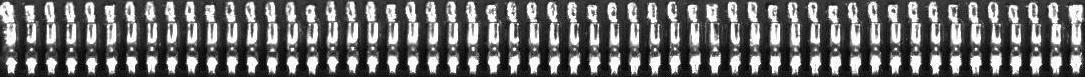

In [124]:
# Path
txt_file_dir = r'D:/FZ_WS/JyNB/TF_Research_Api_LD_2_0/research/object_detection/scripts/Sample-PinPrediction'
test_dir = r'D:\FZ_WS\JyNB\TF_Research_Api_LD_2_0\research\object_detection\images\test'
name='PH9MQV102B1-T(WY20302)_22_4_1-u300___A3.txt'
txt_file = os.path.join(txt_file_dir, name)
_temp=txt_file


#Read
selected_df = get_df(_temp)
selected_df['width'] = selected_df['x2']-selected_df['x1']
selected_df['height'] = selected_df['y2']-selected_df['y1']
selected_df['cx']=(selected_df['x1'] + selected_df['x2'])/2
selected_df['cy']=(selected_df['y1'] + selected_df['y2'])/2
selected_df=dimension_outfilter(selected_df, "width")
selected_df=dimension_outfilter(selected_df, "height")
# print(selected_df)

# Images
img_display = Image(filename=_temp.replace(".txt", ".jpg")) 
display(img_display)
_temp = os.path.join(test_dir, name)
img_display = Image(filename=_temp.replace(".txt", ".jpg")) 
display(img_display)
img = cv2.imread(_temp.replace(".txt", ".jpg"))

## Pitch Estimation

In [103]:
# selected_df=selected_df[:-1]
cx_array = [float(x) for x in list(selected_df["x1"])]
cx_array.sort()
cy_array = [float(x) for x in list(selected_df["y1"])]
cy_array.sort()

def drop_non_mode_pitch(pitch, upper_threshold=1.25):
    p = min(pitch)
    _temp=pitch
    for e in pitch:
        if e> (p * upper_threshold):
            _temp.remove(e)
    return pitch

def gen_pitchx(cx_array):
    pitch_x=[]
    val=0
    for i, _ in enumerate(cx_array[:-1]):
        val = cx_array[i+1]-cx_array[i]
        pitch_x.append(val)
        
    return drop_non_mode_pitch(pitch_x)     
    

# Get Pitch    
arr_pitchX = gen_pitchx(cx_array)    
mean_pitchX=int(round(np.mean(arr_pitchX)))
print("arr_pitchX:{}\t mean:{}".format(arr_pitchX,mean_pitchX))

arr_pitchX:[21.0, 20.0, 20.0, 17.0, 20.0, 21.0, 20.0, 20.0, 20.0, 20.0, 21.0, 19.0, 21.0, 19.0, 19.0, 20.0, 21.0, 20.0, 21.0, 20.0, 20.0, 19.0, 20.0, 20.0, 19.0, 21.0, 20.0, 21.0, 19.0, 20.0, 21.0, 20.0, 19.0, 21.0, 20.0, 20.0, 20.0, 20.0, 19.0, 18.0, 21.0]	 mean:20


## Height and Width calculation

In [126]:
def getAverageWHEstimates(df):
    widths= np.array(df['width'])
    height= np.array(df['height'])
    dw = np.mean(widths)
    dh = np.mean(height)
    return dw, dh
    

def get_x1_LocArray(initial, final, pitch):
    x1_array=[]
    for v in range(initial , 0, -pitch):
        x1_array.append(v)
    
    x1_array.sort()
    x1_array.pop()
    final=int(final*1.1)
    for v in range(initial , final, pitch):
        x1_array.append(v)
    return x1_array
    

def gen_location_coordinates_wrt_onept(selected_df, cx_array, cy_array):
    # Estimated Boxes
    w,h = getAverageWHEstimates(selected_df) 
    _x1=[]
    for i in range(len(cx_array)-1):
        _x1=_x1 + get_x1_LocArray(int(cx_array[13]), int( cx_array[-1]), mean_pitchX)

    _x2=_x1+w
    _y1=np.mean(cy_array)
    _y2=_y1+h
    new_boxes = pd.DataFrame({
            "x1": _x1,
            "y1": _y1,
            "x2": _x2,
            "y2": _y2,
        }
    )
    #print("------------------> x1:", _x1)
    return _x1, _x2, _y1, _y2, new_boxes

def gen_location_coordinates(selected_df, cx_array, cy_array):
    # Estimated Boxes
    w,h = getAverageWHEstimates(selected_df) 
    _x1=[]
    
    _x1=cx_array
    _x2=_x1+w
    _y1=np.mean(cy_array)
    _y2=_y1+h
    new_boxes = pd.DataFrame({
            "x1": _x1,
            "y1": _y1,
            "x2": _x2,
            "y2": _y2,
        }
    )
    #print("------------------> x1:", _x1)
    return _x1, _x2, _y1, _y2, new_boxes


#Calculate estimated boxes
_x1, _x2, _y1, _y2, estimate_boxes = gen_location_coordinates_wrt_onept(selected_df, cx_array, cy_array)
print("------------------> cx_array:{}\n".format(len(cx_array)), cx_array)
selected_df


------------------> cx_array:48
 [63.0, 103.0, 124.0, 144.0, 164.0, 181.0, 204.0, 224.0, 245.0, 265.0, 285.0, 305.0, 325.0, 346.0, 365.0, 386.0, 405.0, 427.0, 446.0, 466.0, 487.0, 507.0, 528.0, 548.0, 568.0, 587.0, 609.0, 629.0, 649.0, 668.0, 689.0, 709.0, 730.0, 749.0, 769.0, 790.0, 810.0, 829.0, 850.0, 870.0, 890.0, 910.0, 930.0, 992.0, 1011.0, 1029.0, 1050.0, 1072.0]


,x1,y1,x2,y2,class,score,width,height,cx,cy
0,649,23,659,70,PIN,0.984342,10,47,654.0,46.5
1,730,24,739,71,PIN,0.983246,9,47,734.5,47.5
2,528,23,538,71,PIN,0.977673,10,48,533.0,47.0
3,749,23,759,70,PIN,0.976662,10,47,754.0,46.5
4,548,24,558,71,PIN,0.976495,10,47,553.0,47.5
5,568,23,577,70,PIN,0.976452,9,47,572.5,46.5
6,466,22,475,70,PIN,0.976061,9,48,470.5,46.0
7,629,24,639,72,PIN,0.973670,10,48,634.0,48.0
8,609,24,618,72,PIN,0.973606,9,48,613.5,48.0
9,668,23,678,71,PIN,0.972203,10,48,673.0,47.0


In [33]:
X = np.array (_x1) //mean_pitchX
print("X", X)
Y=np.array (_x1)
print("Y: ", Y)

m, c =best_fit_slope_and_intercept(X, Y)
x = np.arange(69)
y = m*x+c
np.round(y)

X [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53.
 54.]
Y:  [   7.   27.   47.   66.   86.  106.  126.  146.  166.  186.  206.  226.
  246.  266.  286.  306.  326.  346.  365.  385.  405.  425.  445.  465.
  485.  505.  525.  545.  565.  585.  605.  625.  645.  664.  684.  704.
  724.  744.  764.  784.  804.  824.  844.  864.  884.  904.  924.  944.
  964.  983. 1003. 1023. 1043. 1063. 1083.]


array([   7.,   27.,   47.,   66.,   86.,  106.,  126.,  146.,  166.,
        186.,  206.,  226.,  246.,  266.,  286.,  306.,  326.,  346.,
        365.,  385.,  405.,  425.,  445.,  465.,  485.,  505.,  525.,
        545.,  565.,  585.,  605.,  625.,  645.,  664.,  684.,  704.,
        724.,  744.,  764.,  784.,  804.,  824.,  844.,  864.,  884.,
        904.,  924.,  944.,  963.,  983., 1003., 1023., 1043., 1063.,
       1083., 1103., 1123., 1143., 1163., 1183., 1203., 1223., 1243.,
       1262., 1282., 1302., 1322., 1342., 1362.])

In [101]:

X=np.array(round(selected_df['x1']/mean_pitchX))
Y=np.array(selected_df['x1'])
m, c =best_fit_slope_and_intercept(X, Y)
x = np.arange(0, 55)
y = m*x+c


reg_x = np.round(y)
reg_y = 8 * np.ones_like(reg_x)
_x1, _x2, _y1, _y2, estimate_boxes = gen_location_coordinates(selected_df, reg_x, reg_y)

In [127]:
# def two_split generation():
X=np.array(round(selected_df['x1']/mean_pitchX))
Y=np.array(selected_df['x1'])

#Eq 1:
all_reg_x=[]
all_reg_y=[]
section_idxs = (len (X)//4 )*np.array([1, 2, 3])
r = [0]
for x in section_idxs: r.append(x)
r.append(len(X))
                                       
for i, end_idx in enumerate(section_idxs):
    m, c = best_fit_slope_and_intercept(X[:end_idx], Y[:end_idx])
    x = np.arange(r[i], r[i+1])
    y = m*x+c
    reg_x = np.round(y)
    reg_y = 8 * np.ones_like(reg_x)
    all_reg_x = np.concatenate((all_reg_x, reg_x), axis=0)
    all_reg_y = np.concatenate((all_reg_y, reg_y), axis=0)
print(all_reg_x)

                             

[  2.  22.  42.  63.  83. 103. 123. 143. 164. 184. 204. 224. 249. 269.
 289. 308. 328. 348. 368. 388. 408. 428. 448. 468. 486. 506. 526. 546.
 566. 586. 605. 625. 645. 665. 685. 705.]


In [128]:
_x1, _x2, _y1, _y2, estimate_boxes = gen_location_coordinates(selected_df, all_reg_x, all_reg_y)

#### Save Image

In [129]:
img_dir='D:/FZ_WS/JyNB/TF_Research_Api_LD_2_0/research/object_detection/images/test/'
img_path=os.path.join(img_dir, name).replace('.txt', '.jpg')
img = cv2.imread(img_path)
for i, row in estimate_boxes.iterrows():
    cv2.rectangle(img, (int(row['x1']), int(row['y1'])), ( int(row['x2']), int(row['y2'])), (255,0,0), 2)
    
cv2.imwrite("Test-04.jpg", img)

True

## Identify Invalid

In [158]:
def read(directory, txt_name, img_name):
    selected_df = get_df(txt_name)
    print("Raw selected_df length:\t", len(selected_df))
    selected_df['width'] = selected_df['x2']-selected_df['x1']
    selected_df['height'] = selected_df['y2']-selected_df['y1']
    selected_df['cx']=(selected_df['x1'] + selected_df['x2'])/2
    selected_df['cy']=(selected_df['y1'] + selected_df['y2'])/2
    selected_df=dimension_outfilter(selected_df, "width")
    selected_df=dimension_outfilter(selected_df, "height")
    print("Dimension_outfilter selected_df length:\t", len(selected_df))
    print(selected_df)
    img = cv2.imread(img_name)
    if img is None:
        print("Error: {}".format(img_name))
        return
    
    for i, row in selected_df.iterrows():
        p1=(int(row['x1']), int(row['y1']))
        p2=(int(row['x2']), int(row['y2']))
#         cv2.rectangle(img, p1,p2, (0,255,0), 1)
    print(os.path.basename(img_name))
    if(max(img.shape) >600):
        cv2.imwrite(os.path.basename(img_name.replace(".jpg", "_A.jpg")), img[:, :600])
        cv2.imwrite(os.path.basename(img_name.replace(".jpg", "_B.jpg")), img[:, 500:])
        print("Dim>600")
        pass
    else:
        cv2.imwrite(os.path.basename(img_name), img)
    
read(directory=r'D:/FZ_WS/JyNB/TF_Research_Api_LD_2_0/research/object_detection/images/test',
     txt_name='D:/FZ_WS/JyNB/TF_Research_Api_LD_2_0/research/object_detection/scripts/Sample-PinPrediction/FMC-GN31-MB-679-T_25_7_3-ic603___A0.txt',
     img_name='D:/FZ_WS/JyNB/TF_Research_Api_LD_2_0/research/object_detection/images/test/FMC-GN31-MB-679-T_25_7_3-ic603___A0.jpg') 

Raw selected_df length:	 51
Dimension_outfilter selected_df length:	 45
      x1  y1    x2   y2 class     score  width  height      cx    cy
0    152  31   171  103   PIN  0.990050     19      72   161.5  67.0
1    322  34   340  102   PIN  0.989091     18      68   331.0  68.0
2    357  35   375  101   PIN  0.988389     18      66   366.0  68.0
3    253  31   272  104   PIN  0.988311     19      73   262.5  67.5
4    422  33   441  102   PIN  0.987411     19      69   431.5  67.5
5    724  35   742  102   PIN  0.986759     18      67   733.0  68.5
6    525  34   542  101   PIN  0.986700     17      67   533.5  67.5
7    221  34   240  103   PIN  0.986488     19      69   230.5  68.5
8    491  34   509  101   PIN  0.986462     18      67   500.0  67.5
9    457  34   475  100   PIN  0.986354     18      66   466.0  67.0
10   825  35   843  103   PIN  0.986154     18      68   834.0  69.0
11    17  22    38  101   PIN  0.985847     21      79    27.5  61.5
12   557  35   575  101   PIN  